<a href="https://colab.research.google.com/github/zanderVenter/GEE_misc/blob/master/multiclass_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install rioxarray if you are running this in Colab:

In [134]:
%pip install rioxarray -q

Note: you may need to restart the kernel to use updated packages.


Import relevant libraries for this starter script:

In [135]:
import os
import rioxarray as rxr
import rasterio as rio
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from matplotlib.patches import Patch
import numpy as np
from pathlib import Path

Fetch the satellite imagery and their masks fromt he GitHub repo:

In [136]:
!git clone https://github.com/NINAnor/test-multiclass-segmentation.git

Cloning into 'test-multiclass-segmentation'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 51 (delta 9), reused 1 (delta 0), pack-reused 0
Unpacking objects: 100% (51/51), 56.05 MiB | 4.65 MiB/s, done.


Reset root directory and list the image files

In [137]:
# root = Path('test-multiclass-segmentation/dset-s2-grunnkart')
root = Path('dset-s2-grunnkart')

assert root.exists()

train_imgs = list((root/'tra_scene').glob('*.tif'))
train_masks = list((root/'tra_truth').glob('*.tif'))

val_imgs = list((root/'val_scene').glob('*.tif'))
val_masks = list((root/'val_truth').glob('*.tif'))

# As the images and corresponding masks are matched by name, we will sort both lists to keep them synchronized.
train_imgs.sort(); train_masks.sort(); val_imgs.sort(); val_masks.sort()

Open one image and one mask and plot:

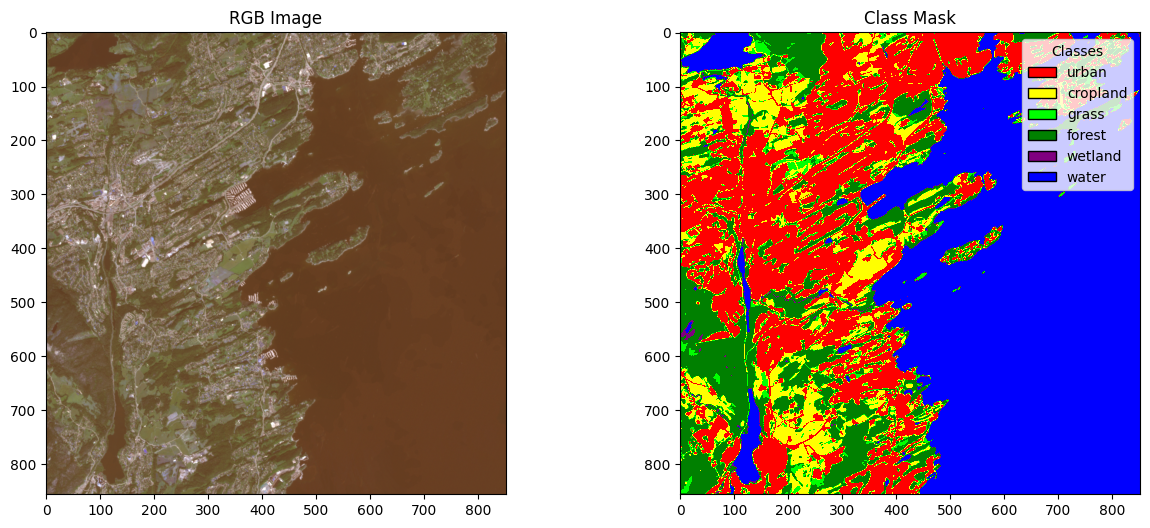

In [138]:
idx = 3
img = rxr.open_rasterio(train_imgs[idx])
mask = rxr.open_rasterio(train_masks[idx])

_, axs = plt.subplots(1, 2, figsize=(15, 6))

# Define the class labels and corresponding colors
class_labels = ['urban', 'cropland', 'grass', 'forest', 'wetland', 'water']
class_colors = ['red', 'yellow', 'lime', 'green', 'purple', 'blue']

# plot the tile
rgb = img.data[[2, 1, 0]].transpose((1, 2, 0))/2000
axs[0].imshow(rgb.clip(min=0, max=1))
axs[0].set_title("RGB Image")

# plot the mask
axs[1].imshow(mask.data.squeeze(), cmap=ListedColormap(class_colors))
axs[1].set_title("Class Mask")
legend_elements = [Patch(facecolor=color, edgecolor='black', label=label)
                   for color, label in zip(class_colors, class_labels)]

# Add the legend to the second subplot
axs[1].legend(handles=legend_elements, loc='upper right', title="Classes")

In [139]:
def read_images_and_masks(indices, train_imgs, train_masks):
    # Define the class labels and corresponding colors
    class_labels = ['urban', 'cropland', 'grass', 'forest', 'wetland', 'water']
    class_colors = ['red', 'yellow', 'lime', 'green', 'purple', 'blue']
    
    # Initialize dictionaries to store images and masks
    images = {}
    masks = {}

    # Loop through the specified indices
    for idx in indices:
        # Read the image and mask files
        images[idx] = rxr.open_rasterio(train_imgs[idx])
        masks[idx] = rxr.open_rasterio(train_masks[idx])
    
    return images, masks, class_labels, class_colors

In [140]:
indices = range(0, 4)  # Indices from 0 to 3

images, masks, class_labels, class_colors = read_images_and_masks(indices, train_imgs, train_masks)

In [141]:
masks[3].shape

(1, 856, 852)

In [142]:
images[0].shape

(6, 851, 848)

In [193]:
def jaccard_score(y_true, y_pred, smooth=1e-6):
    """
    Calculates the Jaccard score, a.k.a IoU for each class and returns the mean.
    
    Args:
    y_true: The ground truth labels.
    y_pred: The predictions.
    smooth: A small constant to avoid division by zero.
    
    Returns:
    The Jaccard score (mean IoU) across all classes.
    """
    # Argmax to convert from one-hot encoded predictions to class integer labels
    y_pred = tf.argmax(y_pred, axis=-1)
    y_true = tf.argmax(y_true, axis=-1)

    # Convert to int32 for intersection and union calculation
    y_pred = tf.cast(y_pred, tf.int32)
    y_true = tf.cast(y_true, tf.int32)
    
    # Calculate Intersection and Union per class
    intersection = tf.math.logical_and(tf.equal(y_true, y_pred), tf.not_equal(y_true, 0)) # Ignoring background class
    union = tf.math.logical_or(tf.equal(y_true, y_pred), tf.not_equal(y_true, 0)) # Ignoring background class
    intersection = tf.reduce_sum(tf.cast(intersection, tf.float32))
    union = tf.reduce_sum(tf.cast(union, tf.float32))
    
    # Compute the IoU and mean over classes
    iou = (intersection + smooth) / (union + smooth)
    return iou

In [201]:
import tensorflow as tf
from tensorflow.keras import layers, models

def conv_block(x, num_filters):
    x = layers.Conv2D(num_filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
    x = layers.Conv2D(num_filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
    return x

def decoder_block(x, skip, num_filters):
    x = layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(x)
    x = layers.concatenate([x, skip])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape, num_classes):
    inputs = layers.Input(input_shape)
    

    # Encoding
    c1 = conv_block(inputs, 64)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    c2 = conv_block(p1, 128)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    c3 = conv_block(p2, 256)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    c4 = conv_block(p3, 512)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    bottleneck = conv_block(p4, 1024)

    # Decoding
    d1 = decoder_block(bottleneck, c4, 512)
    d2 = decoder_block(d1, c3, 256)
    d3 = decoder_block(d2, c2, 128)
    d4 = decoder_block(d3, c1, 64)

    # Output
    outputs = layers.Conv2D(num_classes, (1, 1), padding="same", activation="softmax")(d4)

    model = models.Model(inputs, outputs)
    return model

# Specify the number of classes for your segmentation task
num_classes = 6  # As an example, use 6 classes

# Build the U-Net model
unet_model = build_unet((240, 240, 6), num_classes)
# unet_model.summary()


In [169]:
unet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
import cv2


In [161]:
image_arr = images[0][:, 0:240,0:240] 
image_arr1 = images[1][:, 0:240,0:240] 
image_arr2 = images[2][:, 0:240,0:240] 
image_arr3 = images[3][:, 0:240,0:240] 
images_crop = []
images_crop.append(image_arr1)

images_crop.append(image_arr1)
images_crop.append(image_arr2)
images_crop.append(image_arr3)



In [163]:
images_crop[1].shape

(6, 240, 240)

In [171]:
mask_arr = masks[0][:, 0:240,0:240] 
mask_arr1 = masks[1][:, 0:240,0:240] 
mask_arr2 = masks[2][:, 0:240,0:240] 
mask_arr3 = masks[3][:, 0:240,0:240] 
mask_crop = []
mask_crop.append(mask_arr)

mask_crop.append(mask_arr1)
mask_crop.append(mask_arr2)
mask_crop.append(mask_arr3)
# mask_crop

In [172]:
mask_crop[0].shape

(1, 240, 240)

In [175]:
import numpy as np

def preprocess_volume(volume):
    # Normalize volume
    # volume = volume.astype(np.float32) / 255.0  # Adjust this based on your actual data range
    return volume

def preprocess_mask(mask):
    # One-hot encode mask
    return np.eye(len(class_labels))[mask]  # Assuming mask labels are 0-indexed and match class_labels

volumes = np.array([preprocess_volume(vol) for vol in images])
masks = np.array([preprocess_mask(mask) for mask in masks])

In [176]:
volumes

array([0, 1, 2, 3])

In [198]:
import tensorflow as tf

def load_data(volume, mask):
    return volume, mask

train_dataset = tf.data.Dataset.from_tensor_slices((volumes, masks))
# train_dataset = train_dataset.map(lambda vol, mask: tf.numpy_function(load_data, [vol, mask], [tf.float32, tf.float32]),
                                #   num_parallel_calls=tf.data.AUTOTUNE)
# train_dataset = train_dataset.batch(2)  # Set a suitable batch size
# train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

In [203]:
unet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[jaccard_score, 'accuracy'])
history = unet_model.fit(train_dataset, epochs=50)  # Adjust epochs and add validation data if available

Epoch 1/50


ValueError: Exception encountered when calling Functional.call().

[1mInvalid input shape for input Tensor("functional_13_1/Cast:0", shape=(), dtype=float32). Expected shape (None, 240, 240, 6), but input has incompatible shape ()[0m

Arguments received by Functional.call():
  • inputs=tf.Tensor(shape=(), dtype=int64)
  • training=True
  • mask=None

In [196]:
unet_model

<Functional name=functional_11, built=True>